In [21]:
########## Imports ##########
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
import time

import packages.fonctions as fonctions
from packages import cost

#Preprocessing, Upsampling, Model Selection, Model Evaluation
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score

# Modèle
from sklearn.dummy import DummyClassifier # modèle baseline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set display preferences
pd.set_option('display.max_row', 250)
pd.set_option('display.max_column', 200)

In [22]:
########## Import des données ##########

path = '' #-> en local
filepath = os.path.join(path, 'data/df_train')

with open(filepath, 'rb') as f:
    df = pickle.load(f)

df.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_OUTLIERS,PREVIOUS_LOANS_COUNT,PREV_BUR_MEAN_DAYS_CREDIT,PREV_BUR_MEAN_CREDIT_DAY_OVERDUE,PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE,PREV_BUR_MEAN_DAYS_ENDDATE_FACT,PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE,PREV_BUR_MEAN_CNT_CREDIT_PROLONG,PREV_BUR_MEAN_AMT_CREDIT_SUM,PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT,PREV_BUR_MEAN_AMT_CREDIT_SUM_LIMIT,PREV_BUR_MEAN_AMT_CREDIT_SUM_OVERDUE,PREV_BUR_MEAN_DAYS_CREDIT_UPDATE,PREV_BUR_MEAN_AMT_ANNUITY,PREV_BUR_MEAN_MONTHS_BALANCE_MEAN,PREVIOUS_APPLICATION_COUNT,PREV_APPL_MEAN_AMT_ANNUITY,PREV_APPL_MEAN_AMT_APPLICATION,PREV_APPL_MEAN_AMT_CREDIT,PREV_APPL_MEAN_AMT_DOWN_PAYMENT,PREV_APPL_MEAN_AMT_GOODS_PRICE,PREV_APPL_MEAN_HOUR_APPR_PROCESS_START,PREV_APPL_MEAN_NFLAG_LAST_APPL_IN_DAY,PREV_APPL_MEAN_RATE_DOWN_PAYMENT,PREV_APPL_MEAN_RATE_INTEREST_PRIMARY,PREV_APPL_MEAN_RATE_INTEREST_PRIVILEGED,PREV_APPL_MEAN_DAYS_DECISION,PREV_APPL_MEAN_SELLERPLACE_AREA,PREV_APPL_MEAN_CNT_PAYMENT,PREV_APPL_MEAN_DAYS_FIRST_DRAWING,PREV_APPL_MEAN_DAYS_FIRST_DUE,PREV_APPL_MEAN_DAYS_LAST_DUE_1ST_VERSION,PREV_APPL_MEAN_DAYS_LAST_DUE,PREV_APPL_MEAN_DAYS_TERMINATION,PREV_APPL_MEAN_NFLAG_INSURED_ON_APPROVAL,PREV_APPL_MEAN_CARD_MEAN_MONTHS_BALANCE,PREV_APPL_MEAN_CARD_MEAN_AMT_BALANCE,PREV_APPL_MEAN_CARD_MEAN_AMT_CREDIT_LIMIT_ACTUAL,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_ATM_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_OTHER_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_POS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_INST_MIN_REGULARITY,PREV_APPL_MEAN_CARD_MEAN_AMT_PAYMENT_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_PAYMENT_TOTAL_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_RECEIVABLE_PRINCIPAL,PREV_APPL_MEAN_CARD_MEAN_AMT_RECIVABLE,PREV_APPL_MEAN_CARD_MEAN_AMT_TOTAL_RECEIVABLE,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_ATM_CURRENT,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_OTHER_CURRENT,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_POS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_CNT_INSTALMENT_MATURE_CUM,PREV_APPL_MEAN_CARD_MEAN_SK_DPD,PREV_APPL_MEAN_CARD_MEAN_SK_DPD_DEF,PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_VERSION,PREV_

In [23]:
########## Import des données de la target ##########
filepath = os.path.join(path, 'data/target')

with open(filepath, 'rb') as f:
    df_target = pickle.load(f)

df_target.head()

SK_ID_CURR
100002    1
100003    0
100004    0
100006    0
100007    0
Name: TARGET, dtype: int64

In [24]:
df_target.value_counts()

TARGET
0    267208
1     23845
Name: count, dtype: int64

In [25]:
# Bien plus de 0 que de 1... gros déséquilibre (comme déjà observé pendant l'analyse exploratoire des données)

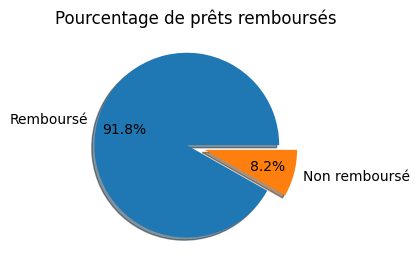

<Figure size 640x480 with 0 Axes>

In [26]:
fig = plt.figure(figsize = (5, 3))
plt.pie(
    df_target.value_counts()/len(df_target)*100,
    autopct = '%1.1f%%',
    explode = [0.1, 0.1],
    pctdistance = 0.7,
    shadow = True,
    labels = ['Remboursé', 'Non remboursé']
       )
plt.title('Pourcentage de prêts remboursés')
plt.show()
plt.savefig('images_presentation/pourcentage_prets.png')

In [27]:
####### Déséquilibre des classes #######

# 2 options :
# - undersampling : parmi les individus majoritaires, on en retire une partie afin d’accorder plus d’importance aux individus minoritaires
# - oversampling : le nombre d’individus minoritaires est augmenté pour qu’ils aient plus d’importance lors de la modélisation

# ici, choix de la 2nd option -> oversampling
# différentes solutions sont possibles, comme le 'clonage' aléatoire ou le SMOTE

In [28]:
####### SMOTE #######
# = Synthetic Minority Oversampling TEchnique
# = méthode de suréchantillonnage des observations minoritaires

# https://kobia.fr/imbalanced-data-smote/
# https://stackoverflow.com/questions/50245684/using-smote-with-gridsearchcv-in-scikit-learn

In [29]:
# -> faire le split avant le smote (on veut pouvoir valider sur des vraies données - on veut que le modèle ait bon sur de vraies données)
# risque -> qu'on utilise des données synthétiques dans le jeu de données test quand on cross valide
# https://www.kaggle.com/discussions/questions-and-answers/427399
# sinon risque de data leakage

# Séparation en train et en test

X = df
y = df_target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

print('train shape :', X_train.shape)
print('test shape :', X_test.shape)

print('train shape (target):', y_train.shape)
print('test shape (target):', y_test.shape)

train shape : (232842, 175)
test shape : (58211, 175)
train shape (target): (232842,)
test shape (target): (58211,)


In [30]:
y_train.value_counts()

TARGET
0    213879
1     18963
Name: count, dtype: int64

In [31]:
round(sum(y_train == 0)/len(y_train)*100, 1)

91.9

In [32]:
print(f'Target 0: {round(sum(y_train == 0)/len(y_train)*100, 1)}% | Target 1: {round(sum(y_train == 1)/len(y_train)*100, 1)}%')

Target 0: 91.9% | Target 1: 8.1%


In [33]:
dc = DummyClassifier()
dc.fit(X_train, y_train)

# Prédictions et évaluations
print(f'AUC = {roc_auc_score(y_test, dc.predict_proba(X_test)[:,1])} | Accuracy = {round(accuracy_score(y_test, dc.predict(X_test)), 2)} | Métrique coût custom = {cost.custom_metric(y_test, dc.predict(X_test))}')

AUC = 0.5 | Accuracy = 0.92 | Métrique coût custom = 4509


In [34]:
# Définition de l'instance SMOTE (valeurs par défaut)
sm = SMOTE(
    k_neighbors = 5, # nombre de plus proches voisins
    sampling_strategy = 'auto', # taux d'observations minoritaires à atteindre
    random_state = 0, # default = None mais ici on essaie de prendre le même random state partout afin d'avoir des résultats comparables
    n_jobs = None # nb de cores CPU utilisés pendant la boucle de cross-validation
    )

# Application du SMOTE aux données
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

In [35]:
y_train_smote.value_counts()

TARGET
0    213879
1    213879
Name: count, dtype: int64

In [36]:
print(f'Target 0: {round(sum(y_train_smote == 0)/len(y_train_smote)*100, 1)}% | Target 1: {round(sum(y_train_smote == 1)/len(y_train_smote)*100, 1)}%')

Target 0: 50.0% | Target 1: 50.0%


In [37]:
###### Tuning SMOTE - k_neighbors ###########

# Compute custom_metric according to k_neighbors
k_value = []

for i in range(2, 20):
    sm = SMOTE(
        k_neighbors = i,
        sampling_strategy = 'auto',
        random_state = 0,
        n_jobs = None
        )

    X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

    print(f'Target 0: {round(sum(y_train_smote == 0)/len(y_train_smote)*100, 1)}% | Target 1: {round(sum(y_train_smote == 1)/len(y_train_smote)*100, 1)}%')

    k_value.append(i)
    dc = DummyClassifier()
    dc.fit(X_train_smote, y_train_smote)

    # Evaluation
    print(f'AUC = {roc_auc_score(y_test, dc.predict_proba(X_test)[:,1])} | Accuracy = {round(accuracy_score(y_test, dc.predict(X_test)), 2)} | Métrique coût custom = {cost.custom_metric(y_test, dc.predict(X_test))}')

Target 0: 50.0% | Target 1: 50.0%
AUC = 0.5 | Accuracy = 0.92 | Métrique coût custom = 4509
Target 0: 50.0% | Target 1: 50.0%
AUC = 0.5 | Accuracy = 0.92 | Métrique coût custom = 4509
Target 0: 50.0% | Target 1: 50.0%
AUC = 0.5 | Accuracy = 0.92 | Métrique coût custom = 4509
Target 0: 50.0% | Target 1: 50.0%
AUC = 0.5 | Accuracy = 0.92 | Métrique coût custom = 4509
Target 0: 50.0% | Target 1: 50.0%
AUC = 0.5 | Accuracy = 0.92 | Métrique coût custom = 4509
Target 0: 50.0% | Target 1: 50.0%
AUC = 0.5 | Accuracy = 0.92 | Métrique coût custom = 4509
Target 0: 50.0% | Target 1: 50.0%
AUC = 0.5 | Accuracy = 0.92 | Métrique coût custom = 4509
Target 0: 50.0% | Target 1: 50.0%
AUC = 0.5 | Accuracy = 0.92 | Métrique coût custom = 4509
Target 0: 50.0% | Target 1: 50.0%
AUC = 0.5 | Accuracy = 0.92 | Métrique coût custom = 4509
Target 0: 50.0% | Target 1: 50.0%
AUC = 0.5 | Accuracy = 0.92 | Métrique coût custom = 4509
Target 0: 50.0% | Target 1: 50.0%
AUC = 0.5 | Accuracy = 0.92 | Métrique coût cu

In [38]:
###### Tuning SMOTE - sampling_strategy ###########

# Compute custom_metric according to sampling_strategy
sampling_value = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.75]:
    print(i)

    sm = SMOTE(
        k_neighbors = 5,
        sampling_strategy = i,
        random_state = 0,
        n_jobs = None
        )

    X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

    print(f'Target 0: {round(sum(y_train_smote == 0)/len(y_train_smote)*100, 1)}% | Target 1: {round(sum(y_train_smote == 1)/len(y_train_smote)*100, 1)}%')

    sampling_value.append(i)
    dc = DummyClassifier()
    dc.fit(X_train_smote, y_train_smote)

    # Evaluation
    print(f'AUC = {roc_auc_score(y_test, dc.predict_proba(X_test)[:,1])} | Accuracy = {round(accuracy_score(y_test, dc.predict(X_test)), 2)} | Métrique coût custom = {cost.custom_metric(y_test, dc.predict(X_test))}')

0.1
Target 0: 90.9% | Target 1: 9.1%
AUC = 0.5 | Accuracy = 0.92 | Métrique coût custom = 4509
0.2
Target 0: 83.3% | Target 1: 16.7%
AUC = 0.5 | Accuracy = 0.92 | Métrique coût custom = 4509
0.3
Target 0: 76.9% | Target 1: 23.1%
AUC = 0.5 | Accuracy = 0.92 | Métrique coût custom = 4509
0.4
Target 0: 71.4% | Target 1: 28.6%
AUC = 0.5 | Accuracy = 0.92 | Métrique coût custom = 4509
0.5
Target 0: 66.7% | Target 1: 33.3%
AUC = 0.5 | Accuracy = 0.92 | Métrique coût custom = 4509
0.75
Target 0: 57.1% | Target 1: 42.9%
AUC = 0.5 | Accuracy = 0.92 | Métrique coût custom = 4509


In [39]:
# conclure ici
# prendre 0.5 ou minority ou all

In [40]:
sm = SMOTE(
    k_neighbors = 5, # nombre de plus proches voisins
    sampling_strategy = 0.5, # taux d'observations minoritaires à atteindre
    random_state = 0,
    n_jobs = None
    )

# Application du SMOTE aux données
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

In [41]:
y_train_smote.value_counts()

TARGET
0    213879
1    106939
Name: count, dtype: int64

In [42]:
print(f'Target 0: {round(sum(y_train_smote == 0)/len(y_train_smote)*100, 1)}% | Target 1: {round(sum(y_train_smote == 1)/len(y_train_smote)*100, 1)}%')

Target 0: 66.7% | Target 1: 33.3%


In [43]:
######## Impact de smote sur perf modeles ######


sm = SMOTE(
    k_neighbors = 5, # nombre de plus proches voisins
    sampling_strategy = 'auto', # taux d'observations minoritaires à atteindre
    random_state = 0,
    n_jobs = None
    )

# Application du SMOTE aux données
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

In [44]:
models = [
    DummyClassifier(), # modèle baseline
    KNeighborsClassifier(), # k-nearest neighbors
    LogisticRegression(), # Regression logistique
    GaussianNB(), # Naives Bayes
    #SVC(), # -> long !! # Support Vector Machines - beaucoup trop long -> exclu d'office
    CatBoostClassifier(logging_level = 'Silent'),
    LGBMClassifier(), # LightGBM
    DecisionTreeClassifier(), # Arbres de decision
    RandomForestClassifier(), # random forest
    AdaBoostClassifier(),
    GradientBoostingClassifier(), # gradient boosting
    XGBClassifier() # XGBoost - erreur sur mac perso mais pas pro
    ]

In [45]:
####### sans smote #######

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
custom = []
time_ = []

for model in models:
    print(type(model).__name__)
    start = time.time()
    results = fonctions.train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    custom.append(results['Custom'])
    time_.append(time.time() - start)

# Créer un dataframe avec résultats
base_models = pd.DataFrame(data = [name, auc, accuracy, precision, recall, f1, custom, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Custom', 'Time']
base_models.sort_values('AUC', ascending = False, inplace = True)
base_models.reset_index(drop = True, inplace = True)
base_models

DummyClassifier
KNeighborsClassifier


LogisticRegression
GaussianNB
CatBoostClassifier
LGBMClassifier
[LightGBM] [Info] Number of positive: 18963, number of negative: 213879
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.375143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27344
[LightGBM] [Info] Number of data points in the train set: 232842, number of used features: 171
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081441 -> initscore=-2.422921
[LightGBM] [Info] Start training from score -2.422921
DecisionTreeClassifier
RandomForestClassifier


In [ ]:
####### avec smote #######

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
custom = []
time_ = []

for model in models:
    print(type(model).__name__)
    start = time.time()
    results = fonctions.train_models(model, X_train_smote, X_test, y_train_smote, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    custom.append(results['Custom'])
    time_.append(time.time() - start)

# Créer un dataframe avec résultats
base_models = pd.DataFrame(data = [name, auc, accuracy, precision, recall, f1, custom, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Custom', 'Time']
base_models.sort_values('AUC', ascending = False, inplace = True)
base_models.reset_index(drop = True, inplace = True)
base_models

DummyClassifier
KNeighborsClassifier
LogisticRegression
GaussianNB
CatBoostClassifier
LGBMClassifier
[LightGBM] [Info] Number of positive: 213879, number of negative: 213879
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.181135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38078
[LightGBM] [Info] Number of data points in the train set: 427758, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier


,Model,AUC,Accuracy,Precision,Recall,F1,Custom,Time
0,CatBoostClassifier,0.761734,0.915858,0.480296,0.039943,0.073752,6264,334.325411
1,XGBClassifier,0.749036,0.914569,0.413002,0.044244,0.079926,6453,319.469159
2,LGBMClassifier,0.745436,0.915995,0.479381,0.01905,0.036643,5346,21.405607
3,LogisticRegression,0.740638,0.69279,0.165629,0.659566,0.26477,33489,21.731204
4,RandomForestClassifier,0.686856,0.91426,0.316498,0.019254,0.0363,5355,656.771761
5,GradientBoostingClassifier,0.686599,0.912937,0.296053,0.027653,0.050581,5724,922.191504
6,AdaBoostClassifier,0.661805,0.867139,0.182264,0.167554,0.1746,11871,172.20062
7,KNeighborsClassifier,0.607985,0.629434,0.11675,0.520688,0.190733,27387,636.42626
8,GaussianNB,0.550602,0.221144,0.089029,0.897583,0.16199,43947,2.50752
9,DecisionTreeClassifier,0.534654,0.830462,0.12988,0.17923,0.150615,12384,109.971479
